# Exogenous Uniswap Process modeling, Percent Change

##### Note: This is a copy of Uniswap_Process_Modeling.ipynb that uses percent of change instead of absolute values. This produces liquidity demand events(swaps and add liquidity) that are percents of the pool and thus not dependent upon historical pool sizes

## Liquidity demand stochastic process

1. Acquire time series of order book for single collateral DAI 2017-2019; this is the proxy for the liquidity demand of RAI
2. Fit a parametric distribution to the data, resulting in a distribution $F^D_{RAI}(t;\mu_{RAI})$ and fitted parameters $\mu_{RAI}$.


To obtain this data, we ran a [Uniswap cadCAD model](https://github.com/cadCAD-org/demos/tree/master/demos/Multiscale/uniswap) twice, once to obtain Buy/Sell univariate time series data and once for obtaining univariate time series liquidity data. Shown below is the modification between runs. We then saved these runs as csv files and continue bring the data into this notebook for building stochastic generators.


```
# Mechanisms
def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    # 1 Buy/Sell
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    # 2 Add/remove liquidity
#     if action == 'AddLiquidity':
#         return addLiquidity_DAI(params, step, history, current_state, input_)
#     elif action == 'Transfer':
#         return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', abs(current_state['DAI_balance']))
```

In [1]:
# import libraries
import pandas as pd
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline

In [2]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python?lq=1
def get_best_distribution(data):
    dist_names = ["alpha","gamma","norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]


def kl_divergence(p, q):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))

## Data preprocessing


We examine the data two univariate time series,buy/sell and liquidity, make changes absolute, and remove all zero values.

In [3]:
# import data
buy_sell_uniswap_events = pd.read_csv('data/uniswap_data_buy_sell.csv')
liquidity_uniswap_events = pd.read_csv('data/uniswap_liquidity_data.csv')

buy_sell_uniswap_events.head()

,Unnamed: 0,DAI_balance,ETH_balance,UNI_supply,simulation,subset,run,substep,timestep
0,1,5905000000000000000000,29974673940746674209,30000000000000000000,0,0,1,1,1
1,2,5907000000000000000000,29964555511671268196,30000000000000000000,0,0,1,1,2
2,3,5905035238623641640532,29974555511671268196,30000000000000000000,0,0,1,1,3
3,4,5903071785798411448958,29984555511671268196,30000000000000000000,0,0,1,1,4
4,5,5901109640216828255225,29994555511671268196,30000000000000000000,0,0,1,1,5


In [4]:
liquidity_uniswap_events.head()

,Unnamed: 0,DAI_balance,ETH_balance,UNI_supply,simulation,subset,run,substep,timestep
0,1,5900000000000000000000,29974673940746674209,30000000000000000000,0,0,1,1,1
1,2,5900000000000000000000,29964546939628433685,30000000000000000000,0,0,1,1,2
2,3,5900000000000000000000,29974546939628433685,30000000000000000000,0,0,1,1,3
3,4,5900000000000000000000,29984546939628433685,30000000000000000000,0,0,1,1,4
4,5,5900000000000000000000,29994546939628433685,30000000000000000000,0,0,1,1,5


<AxesSubplot:title={'center':'Dai liquidity univariate series'}, xlabel='timestep'>

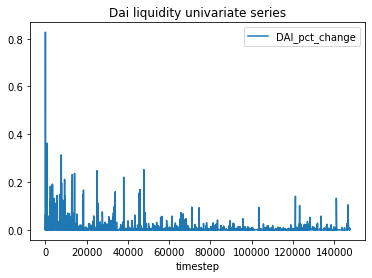

In [5]:
# liquidity series
liquidity_uniswap_events['DAI_balance'] = liquidity_uniswap_events['DAI_balance'].astype(float)
liquidity_uniswap_events['DAI_pct_change'] = abs(liquidity_uniswap_events['DAI_balance'].pct_change())
liquidity_uniswap_events['DAI_pct_change'].fillna(0,inplace=True)
liquidity_uniswap_events = liquidity_uniswap_events.query('DAI_pct_change > 0') 
liquidity_uniswap_events.plot(x='timestep',y='DAI_pct_change',title='Dai liquidity univariate series')

Text(0.5, 1.0, 'Histogram of Liquidity IID Samples')

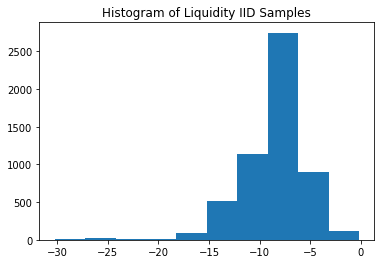

In [6]:
plt.hist(liquidity_uniswap_events['DAI_pct_change'].apply(np.log))
plt.title('Histogram of Liquidity IID Samples')

<AxesSubplot:title={'center':'Dai Buy/Sell Univariate Series'}, xlabel='timestep'>

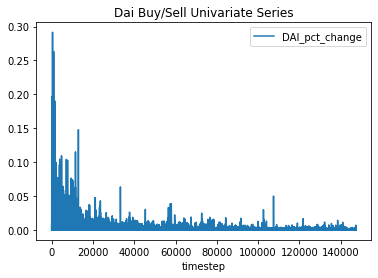

In [7]:
# buy/sell series
buy_sell_uniswap_events['DAI_balance'] = buy_sell_uniswap_events['DAI_balance'].astype(float)
buy_sell_uniswap_events['DAI_pct_change'] = abs(buy_sell_uniswap_events['DAI_balance'].pct_change())
buy_sell_uniswap_events['DAI_pct_change'].fillna(0,inplace=True)
buy_sell_uniswap_events = buy_sell_uniswap_events.query('DAI_pct_change > 0') 
buy_sell_uniswap_events.plot(x='timestep',y='DAI_pct_change',title='Dai Buy/Sell Univariate Series')

Text(0.5, 1.0, 'Histogram of Buy/Sell IID Samples')

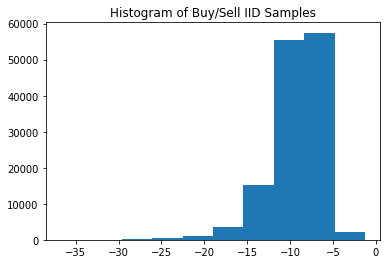

In [8]:
plt.hist(buy_sell_uniswap_events['DAI_pct_change'].apply(np.log))
plt.title('Histogram of Buy/Sell IID Samples')

## Distribution fitting

We take the log of liquidity data prior to fitting to make the trend more discernible. We fit both the liquidity and buy/sell univariate series to an alpha distribution. 

In [9]:
# We take the log of liquidity data prior to fitting to make the trend more discernible 
#distribution, pvalue, params = get_best_distribution(liquidity_uniswap_events['DAI_diff'].apply(np.log).values)

In [10]:
# fit liquidity to the alpha distribution.
fit_shape_liquidity, fit_loc_liquidity, fit_scale_liquidity =st.alpha.fit(liquidity_uniswap_events['DAI_pct_change'].apply(np.log).values)


/Users/georgekellerman/github/geb-sims/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [11]:
timesteps = 24 * 365 # 24 hours a day * 365 days a year 
timesteps

8760

Text(0.5, 1.0, 'Histogram of Liquidity IID Samples')

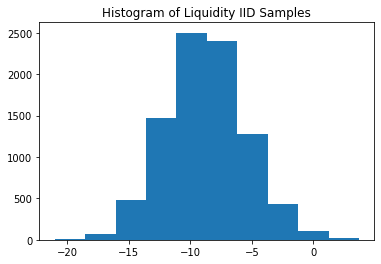

In [12]:
# 8760 timestamp sample histogram
liquidity = st.alpha.rvs(fit_shape_liquidity, loc=fit_loc_liquidity, scale=fit_scale_liquidity, size=timesteps)
plt.hist(liquidity)
plt.title('Histogram of Liquidity IID Samples')

Text(0.5, 1.0, 'Histogram of Liquidity IID Samples against original data')

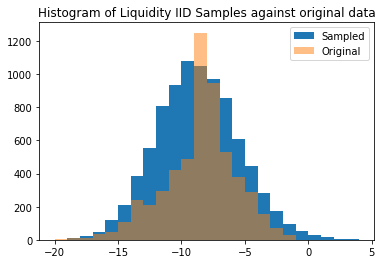

In [13]:
plt.hist(liquidity,bins=np.arange(-20, 5),label='Sampled')
plt.hist(liquidity_uniswap_events['DAI_pct_change'].apply(np.log),alpha=0.5,bins=np.arange(-20, 5),label='Original')
plt.legend()
plt.title('Histogram of Liquidity IID Samples against original data')

In [14]:
# hist,bins = np.histogram(liquidity,bins=50)
# hist_original, bins = np.histogram(liquidity_uniswap_events['DAI_diff'].apply(np.log),bins=50) 
# kl_divergence(hist,hist_original)

Text(0.5, 1.0, 'Time Series of Liquidity IID Samples')

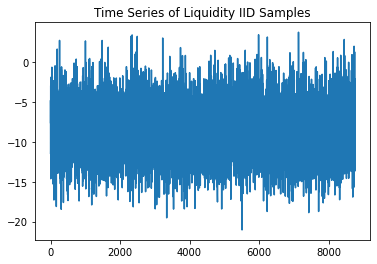

In [15]:
plt.plot(liquidity)
plt.title('Time Series of Liquidity IID Samples')

In [16]:
# export liquidity series
liquidity_samples = pd.DataFrame(np.exp(liquidity),columns=['Liquidity_Samples'])
liquidity_samples.to_csv('data/liquidity_samples.csv')

In [17]:
# fit buy/sell series distribution
#distribution, pvalue, params = get_best_distribution(buy_sell_uniswap_events['DAI_diff'].apply(np.log).values)

In [18]:
# Fit buy/sell series
fit_shape_buy_sell, fit_loc_buy_sell, fit_scale_buy_sell = st.alpha.fit(buy_sell_uniswap_events['DAI_pct_change'].apply(np.log).values)

/Users/georgekellerman/github/geb-sims/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Text(0.5, 1.0, 'Histogram of Buy Sell IID Samples')

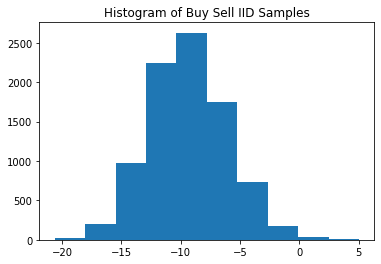

In [19]:
buy_sell = st.alpha.rvs(fit_shape_buy_sell, loc=fit_loc_buy_sell, scale=fit_scale_buy_sell, size=timesteps)

plt.hist(buy_sell)
plt.title('Histogram of Buy Sell IID Samples')

Text(0.5, 1.0, 'Time Series of Buy Sell IID Samples')

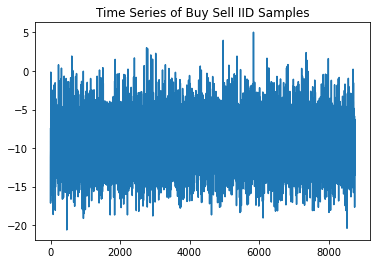

In [20]:
plt.plot(buy_sell)
plt.title('Time Series of Buy Sell IID Samples')

Text(0.5, 1.0, 'Histogram of Buy/Sell IID Samples against original data')

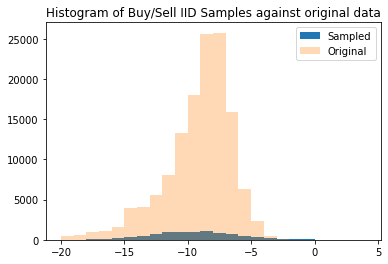

In [21]:
plt.hist(buy_sell,bins=np.arange(-20, 5),label='Sampled')
plt.hist(buy_sell_uniswap_events['DAI_pct_change'].apply(np.log),alpha=0.3,bins=np.arange(-20, 5),label='Original')
plt.legend()
plt.title('Histogram of Buy/Sell IID Samples against original data')

In [22]:
# Export buy/sell time series
buy_sell_samples = pd.DataFrame(np.exp(buy_sell),columns=['Buy_Sell_Samples'])
buy_sell_samples.to_csv('data/buy_sell.csv')

## Generate Monte Carlo runs
### Buy/Sell Events

In [23]:
monte_carlo_runs = 100

buy_sell_mc = {}
for run in range(0, monte_carlo_runs):
    np.random.seed(seed=run)
    
    buy_sell = st.alpha.rvs(fit_shape_buy_sell, loc=fit_loc_buy_sell, scale=fit_scale_buy_sell, size=timesteps + 1)
    buy_sell_mc[run] = np.exp(buy_sell)

buy_sell_mc_df = pd.DataFrame(buy_sell_mc)
buy_sell_mc_df.to_csv('data/buy_sell_pct_mc.csv')
buy_sell_mc_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.111313e-04,3.741540e-05,4.378792e-05,0.000113,4.378624e-02,0.000006,5.107329e-03,8.136933e-07,0.003601,5.992266e-08,...,2.831118e-06,5.043949e-06,4.482212e-03,0.000181,0.000517,6.802421e-06,0.000006,2.052471e-03,0.000590,3.274830e-04
1,4.955300e-04,5.217880e-04,1.752802e-07,0.000462,1.096730e-04,0.003442,1.811356e-05,9.925417e-04,0.047281,7.531794e-05,...,3.006714e-06,1.764581e-05,1.098902e-03,0.000286,0.000183,4.488121e-06,0.007173,5.173320e-02,0.000130,6.723351e-05
2,1.756759e-04,1.315510e-09,1.119227e-04,0.000012,5.939300e-02,0.000005,1.655244e-03,4.467024e-05,0.003355,7.162761e-05,...,1.568135e-01,1.315776e-05,3.988821e-05,0.000015,0.000387,4.521688e-03,0.001570,4.801290e-05,0.000014,1.752472e-03
3,1.075437e-04,1.388118e-05,4.354517e-05,0.000081,4.936827e-04,0.008822,3.294308e-07,5.386631e-04,0.000096,2.176527e-06,...,6.446162e-03,1.136120e-06,6.233048e-05,0.034596,0.000039,5.144761e-04,0.006364,1.177848e-05,0.001000,2.248683e-07
4,3.953465e-05,2.603812e-06,3.847047e-05,0.005116,4.172120e-04,0.000067,1.456936e-06,8.346147e-02,0.000007,2.444359e-06,...,4.254989e-06,1.829003e-05,2.948794e-09,0.000100,0.000049,9.740396e-05,0.000456,8.982697e-04,0.000073,1.395365e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2.481629e-04,1.336842e-04,8.161811e-06,0.000007,9.253393e-08,0.002652,9.072659e-04,1.083187e-03,0.000090,1.199799e-06,...,1.482368e-04,3.935437e-05,4.092966e-04,0.000007,0.020007,1.202804e-05,0.000076,2.103457e-03,0.001873,2.169403e-05
8757,1.271625e-05,1.191073e-02,1.351130e-06,0.001839,2.711641e-03,0.000334,3.240008e-03,1.087173e-05,0.000121,1.290075e-03,...,9.849775e-08,3.926120e-03,1.104553e-04,0.000009,0.000002,7.381132e-05,0.000113,1.019942e-07,0.006190,5.218007e-06
8758,4.632629e-04,8.874603e-06,6.449469e-07,0.000004,4.822226e-06,0.000177,4.540010e-05,6.241114e-08,0.000595,2.011416e-03,...,4.651045e-06,1.123421e-06,3.431464e-04,0.000056,0.000028,1.893612e-03,0.000010,6.733115e-07,0.000001,1.625392e-06
8759,8.142034e-03,2.826485e-04,4.241836e-05,0.003179,7.014861e-06,0.000002,1.677822e-03,2.177009e-05,0.000295,1.228324e-04,...,2.011048e-04,4.205319e-04,1.288658e-01,0.000016,0.000012,1.150337e-05,0.000003,5.441294e-03,0.000039,5.263017e-03


### Liquidity Demand Events

In [24]:
monte_carlo_runs = 100

liquidity_mc = {}
for run in range(0, monte_carlo_runs):
    np.random.seed(seed=run)
    
    liquidity = st.alpha.rvs(fit_shape_liquidity, loc=fit_loc_liquidity, scale=fit_scale_liquidity, size=timesteps + 1)
    liquidity_mc[run] = np.exp(liquidity)

liquidity_mc_df = pd.DataFrame(liquidity_mc)
liquidity_mc_df.to_csv('data/liquidity_pct_mc.csv')
liquidity_mc_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.114537e-04,7.166072e-05,8.377357e-05,0.000215,8.399611e-02,0.000012,9.684625e-03,1.626230e-06,0.006822,1.254297e-07,...,5.561804e-06,9.841067e-06,8.495954e-03,0.000344,0.000978,1.322836e-05,0.000011,3.884274e-03,0.001116,6.205791e-04
1,9.381681e-04,9.877934e-04,3.593732e-07,0.000875,2.086925e-04,0.006520,3.489221e-05,1.877771e-03,0.090754,1.436063e-04,...,5.902348e-06,3.399891e-05,2.078946e-03,0.000542,0.000347,8.768305e-06,0.013618,9.937087e-02,0.000247,1.282768e-04
2,3.335890e-04,3.020951e-09,2.129521e-04,0.000024,1.142128e-01,0.000010,3.131869e-03,8.544998e-05,0.006355,1.366096e-04,...,3.043022e-01,2.541884e-05,7.636215e-05,0.000028,0.000733,8.570994e-03,0.002971,9.179964e-05,0.000027,3.315985e-03
3,2.046605e-04,2.680309e-05,8.331232e-05,0.000155,9.346768e-04,0.016762,6.679821e-07,1.019686e-03,0.000182,4.290226e-06,...,1.223294e-02,2.259494e-06,1.189765e-04,0.066250,0.000076,9.739744e-04,0.012076,2.277809e-05,0.001892,4.589854e-07
4,7.569003e-05,5.120647e-06,7.366685e-05,0.009701,7.901577e-04,0.000129,2.887367e-06,1.609711e-01,0.000014,4.810938e-06,...,8.317991e-06,3.522918e-05,6.624026e-09,0.000190,0.000095,1.854573e-04,0.000864,1.699492e-03,0.000139,2.639895e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,4.706507e-04,2.541449e-04,1.584155e-05,0.000014,1.920196e-07,0.005021,1.716503e-03,2.049219e-03,0.000171,2.384275e-06,...,2.816822e-04,7.534732e-05,7.751987e-04,0.000013,0.038174,2.325605e-05,0.000144,3.980883e-03,0.003543,4.172541e-05
8757,2.457376e-05,2.266231e-02,2.680497e-06,0.003480,5.133883e-03,0.000632,6.136386e-03,2.104080e-05,0.000230,2.440639e-03,...,2.041472e-07,7.439222e-03,2.101738e-04,0.000018,0.000004,1.407500e-04,0.000215,2.112514e-07,0.011744,1.017677e-05
8758,8.771871e-04,1.721029e-05,1.293570e-06,0.000007,9.413275e-06,0.000337,8.683659e-05,1.305305e-07,0.001126,3.806486e-03,...,9.082876e-06,2.234602e-06,6.501824e-04,0.000107,0.000053,3.583311e-03,0.000020,1.349560e-06,0.000002,3.216371e-06
8759,1.546514e-02,5.358386e-04,8.117110e-05,0.006020,1.363701e-05,0.000004,3.174621e-03,4.187048e-05,0.000559,2.336058e-04,...,3.816793e-04,7.964318e-04,2.495697e-01,0.000030,0.000024,2.225111e-05,0.000005,1.031998e-02,0.000074,9.980789e-03


## Implementation information
Below is an example of how to integrate these univariate time series datasets into the exogenous process section of a cadCAD model, assuming each timestep is an hour.

```
# exogenousProcesses.py

# import libraries
import pandas as pd

# import data
liquidity_samples = pd.read_csv('data/liquidity_samples.csv')
buy_sell_samples = pd.read_csv('data/buy_sell.csv')

# mechanisms
def liquidity_exogenous_process(params, step, sL, s, _input):
    y = 'liquidity'
    timestep = s['timestep'] 
    x = liquidity_samples.Liquidity_Samples.values[timestep]
    return (y, x)
    
def buy_sell_exogenous_process(params, step, sL, s, _input):
    y = 'buy_sell'
    timestep = s['timestep'] 
    x = buy_sell_samples.Buy_Sell_Samples.values[timestep]
    return (y, x)
    
```